# Wildfire risk forecasting in the USA using ClimaX and time-series weather datacube

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Necessary imports](#2)
* [Connect to ArcGIS](#3)
* [Accessing the dataset](#4) 
* [Prepare training data for ClimaX](#5)
* [Visualize training data](#6)
* [Model training](#10) 
* [Model accuracy and validation](#15)
* [Save the model](#16) 
* [Inferencing in ArcGIS Pro](#18) 
* [Visualize results](#19) 
* [Conclusion](#20)

## Introduction <a class="anchor" id="1"></a>

Wildfires are an increasingly prevalent and destructive natural disaster, particularly in regions of the United States that are prone to dry conditions, high temperatures, and droughts. The unpredictability of wildfires poses significant challenges for disaster management, risk assessment, and environmental protection. Accurate forecasting of wildfire likelihood is crucial for enabling early intervention and effective resource allocation in affected regions.

This project aims to leverage cutting-edge technologies in machine learning and climate data analysis to forecast the likelihood of wildfires in the United States. Specifically, it utilizes the pretrained `ClimaX` foundational model—a state-of-the-art machine learning model by Microsoft, designed for forecasting weather and climate tasks as well as events impacted by them such as wildfires. Here, the model utilizes a multi-dimensional time-series dataset the Wildfire Weather Cube. This dataset contains historical data on key weather parameters such as temperature, humidity, wind speed, precipitation etc. recorded from 2001 to 2021, which are critical in predicting the conditions conducive to wildfires. 

The project intends to generate a  likelihood raster of wildfire risk, enabling more informed decision-making for emergency response teams, policymakers, and communities. The objective is to provide actionable insights into when and where such events are most likely to occur, based on historical weather patterns and climate projections.

## Necessary imports <a class="anchor" id="2"></a>

In [1]:
import os
from pathlib import Path
import zipfile

import arcgis
from arcgis.gis import GIS
from arcgis.learn import prepare_data, ClimaX

## Connect to ArcGIS <a class="anchor" id="3"></a>

In [2]:
# Connect to GIS
gis = GIS('home')

## Accessing the dataset <a class="anchor" id="4"></a>

Here we will be using a multidimensional datacube for seasonal fire forecasting around the globe, created by the European Space Agency (ESA). The dataset spans 21 years (2001-2021) with an 8-day time resolution and a 0.25-degree grid resolution. It encompasses a wide variety of seasonal fire drivers, including atmospheric and climatological factors, vegetation variables, socioeconomic data, and other variables related to wildfires. We have pre-processed the data extracting the relevant variables for forecasting the target variable, `fwi_max` which represent the maximum Fire Weather Index (FWI), a composite index measure used to assess fire risk based on weather and environmental conditions and made it available here.

<Item title:"wildfire_weather_cube_2001_2021_crf" type:Image Collection owner:api_data_owner>
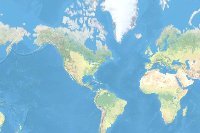

In [3]:
input_feature_class = gis.content.get('255298ee7dd14e2c9d0f0293dce17bba')
input_feature_class

## Prepare training data for ClimaX <a class="anchor" id="5"></a>


First we will export the training data for ClimaX. To export training data, we will use the wildfire weather multidimensional time series cube as the input raster. This input raster is a satellite-based, [multi-dimensional time series raster](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm) that includes the necessary time steps. The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool will be utilized to export the training data for the model. 

The tool is available in ArcGIS Pro and ArcGIS Image Server. Below are the used parameters used in the export tool.

- `Input Raster`: wildfire_weather_cube_2001_2021.crf
- `Output Folder`: 'D:\Climax_training_data'
- `Tile Size X & Tile Size Y`: 121, 121
- `Stride X & Stride Y`: 121, 121
- `Meta Data Format`: 'Export Tiles'
- `Environments`: Set `Cell Size` and `Processing Extent` as per input raster

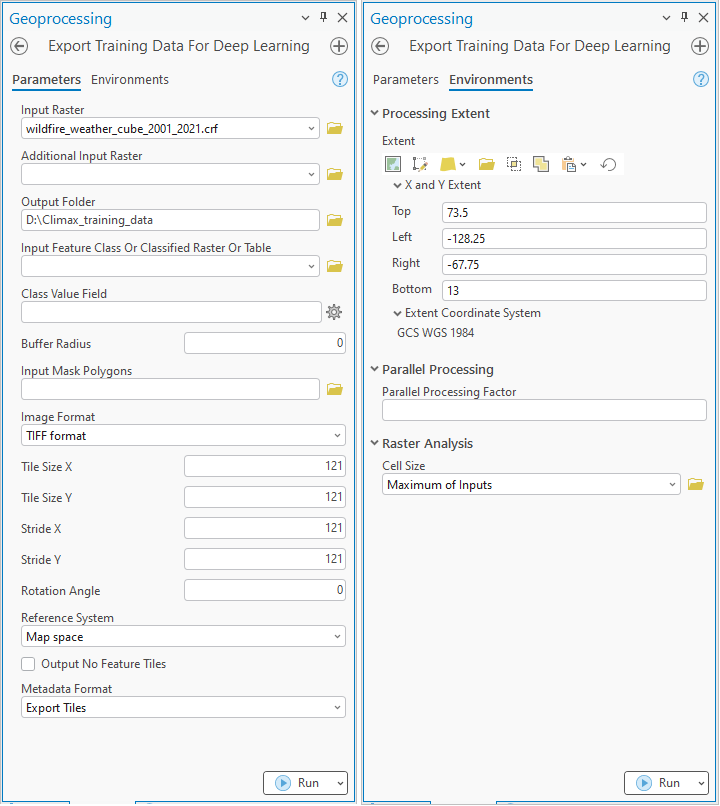


We have already exported the prepared data and made it available so that it can be used by following the steps below.

<Item title:"ClimaX_training_data" type:Image Collection owner:api_data_owner>
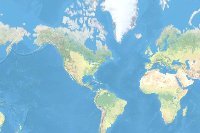

In [4]:
training_data = gis.content.get('9efe9afb45714c6181056b0fbca48970')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

For data preparation using the exported data, we use `prepare_data` available in `arcgis.learn`. We will specify the path to our training data and a few hyperparameters.

- `path` - Required string. path of the folder containing training data.
- `batch_size` - Required int. number of timesteps your model will train on each step inside an epoch.
- `forecast_timesteps` - Required int. Set to 1. This represents how far the model should forecast into the future while training. Here we have 8 day interval data. So, setting the forecast timesteps to 1, 2, 3 will make 8, 16, 32 days forecast timestep respectively.
- `hrs_each_step` - The data interval in terms of hours in which data is collected. Here since it is 8 days interval data, this is set to 192 hrs (8 days * 24 hrs).

In [8]:
data = prepare_data(data_path, 
                    batch_size=4,
                    forecast_timesteps=1, # how far the model should forecast into the future
                    hrs_each_step=192,     # time difference between two consecutive recorded data points in the dataset in hrs
                    )

We will develop a model to forecast the target variable, fwi_max, to predict the likelihood of wildfire for USA, under specific conditions. This will utilize some relevant variables that have a strong direct relationship with fire weather conditions or are highly correlated with other key variables.

The following list outlines the variables that the model will train and generate as part of the forecast or prediction task. These variables are typically linked to meteorological and environmental data, such as weather patterns, land cover, and climate indices, all of which are commonly used in forecasting climate-related events like wildfires. Below is a detailed description of what each variable represents:

1. **drought_code_max**: The maximum value of the drought code, which quantifies the severity of drought conditions.
2. **drought_code_mean**: The mean (average) value of the drought code, representing the general drought conditions over time.
3. **fwi_max**: The maximum Fire Weather Index (FWI), a composite index measure used to assess fire risk based on weather and environmental conditions. A higher value indicates a higher risk of fire occurrence and the likelihood of fire under given conditions.
4. **fwi_mean**: The average Fire Weather Index (FWI), indicating general fire risk conditions.
5. **lai**: Leaf Area Index, a measure of the total leaf area relative to the ground area in vegetation. Provides insight into vegetation density, which affects fuel availability.
6. **lccs_class_1**:  Agricultural areas.
7. **lccs_class_2**: Forests and woodlands.
8. **lccs_class_3**: Grasslands and pastures.
9. **lccs_class_4**: Wetlands.
10. **lccs_class_5**: Settlement or Urban areas.
11. **lccs_class_6**: Shrubland.
12. **lccs_class_7**: Sparse vegetation, bare areas, barren land,  permanent snow and ice.
13. **lccs_class_8**: Water bodies (rivers, lakes, etc.)
14. **lst_day**: Land Surface Temperature during the day.
15. **mslp**: Mean Sea-Level Pressure.
16. **ndvi**: Normalized Difference Vegetation Index, which indicates vegetation health and moisture, impacting fire risk.
17. **pop_dens**: Population density.
18. **rel_hum**: Relative humidity, a measure of the amount of moisture in the air. Lower humidity levels increase fire risk, making it highly relevant.
19. **skt**: Skin temperature, referring to the temperature of the Earth's surface, which can influence fire behavior.
20. **ssr**: Surface Solar Radiation, representing the amount of solar energy reaching the Earth's surface.
21. **ssrd**: Surface Solar Radiation Downward, the portion of solar radiation reaching the ground.
22. **sst**: Sea Surface Temperature.
23. **swvl1**: Soil Water Volumetric Content at level 1 (refers to the moisture in the top soil layer).
24. **t2m_max**: Maximum 2-meter temperature, indicating the highest air temperature measured at 2 meters above the surface. Higher temperatures increase fire danger.
25. **t2m_mean**: Mean 2-meter temperature, the average air temperature measured at 2 meters. Average temperature affects fire risk.
26. **t2m_min**: Minimum 2-meter temperature, indicating the lowest air temperature measured at 2 meters. Indicates fire risk.
27. **tp**: Total precipitation, the amount of rainfall or snowfall over a specific period. Precipitation influences vegetation moisture, indirectly affecting fire risk.
28. **vpd**: Vapor Pressure Deficit, a measure of the dryness of the air, which directly impacts fire weather conditions.
29. **ws10**: Wind speed at 10 meters. Wind speed impacts fire spread and intensity.

## Visualize training data <a class="anchor" id="6"></a>

To get a sense of what the training data looks like, the show_batch() method will randomly pick a few training chips and visualize them. The chips are input state representing past data and future state showing forecasted state.

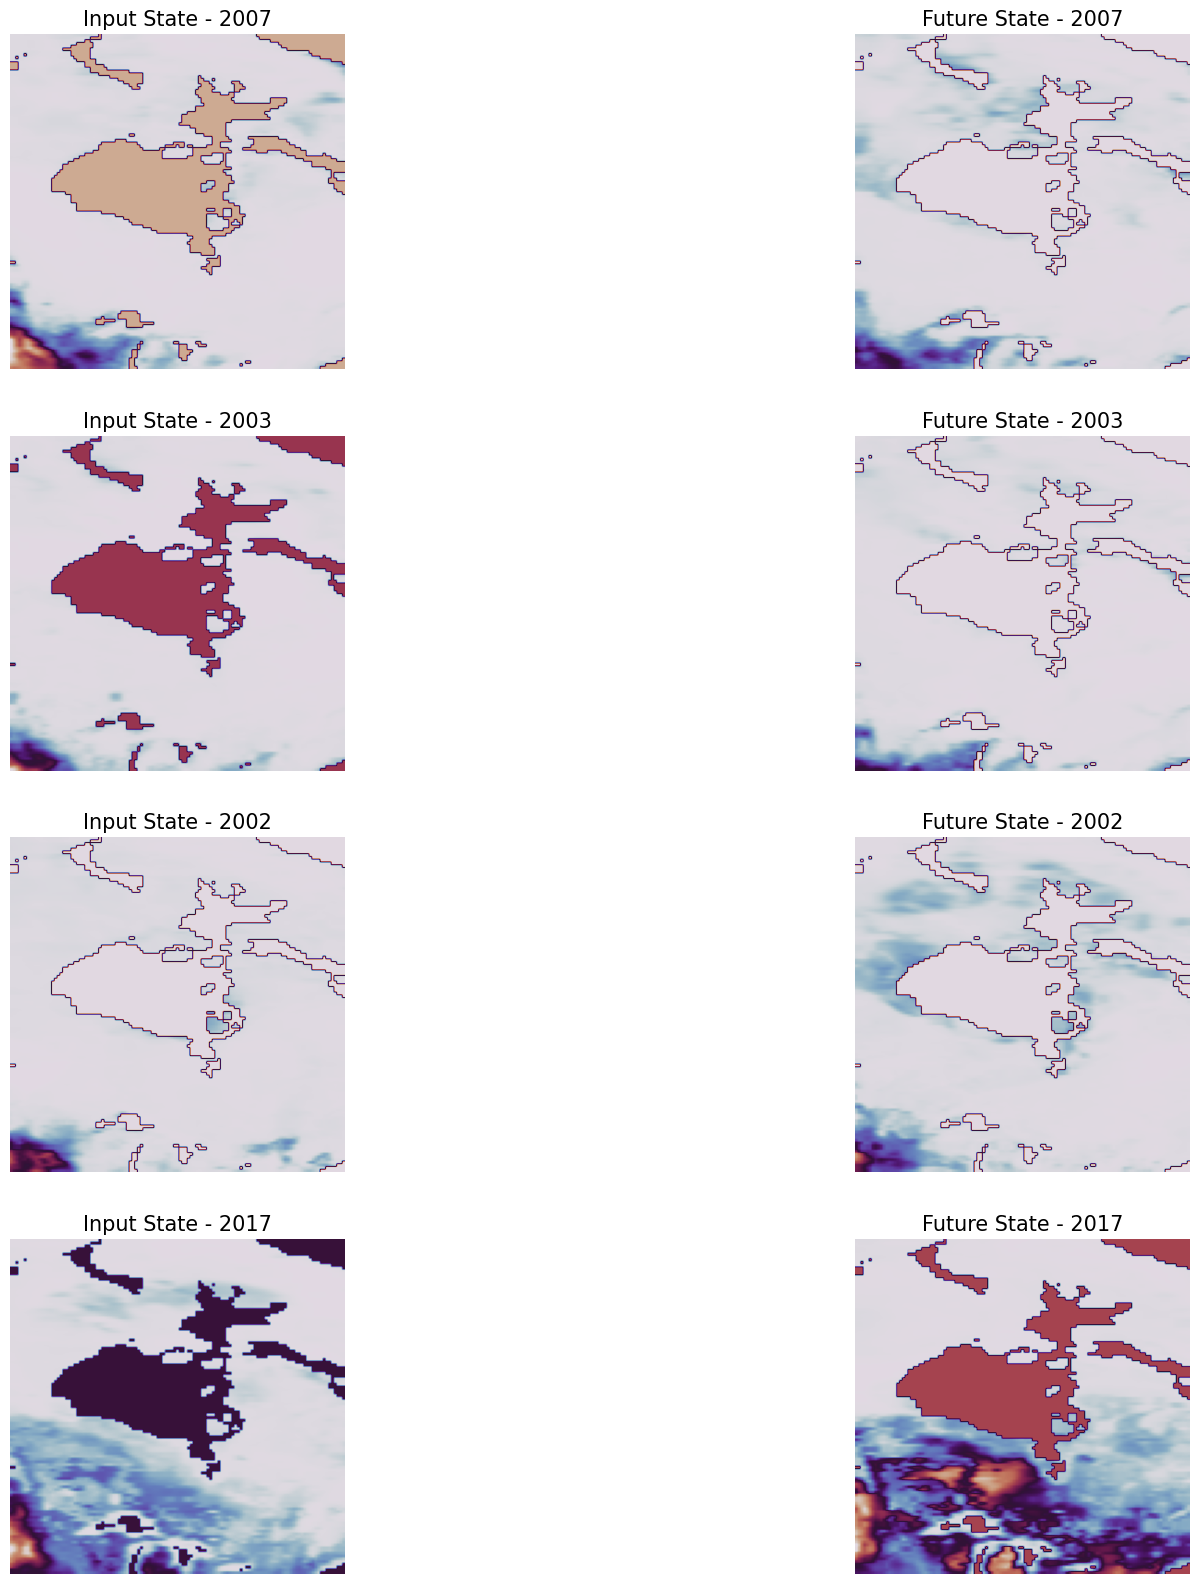

In [11]:
data.show_batch(variable='fwi_max')

## Model training <a class="anchor" id="10"></a>

Here we will define the ClimaX model architecture. The default, initialization of the `ClimaX` model object is shown below:

In [12]:
model=ClimaX(data, backbone='1.40625deg', patch_size=4)

Currently, two backbone resolutions of `5.625deg` and `1.40625deg` are available for the ClimaX model, with `5.625deg` set as the default. Here, we will be utilizing the `1.40625deg` resolution backbone, which provides higher granularity and improved performance.

For the second parameter, we use `patch_size`, which is an optional integer parameter used for generating patch embeddings. A smaller patch size results in finer granularity, allowing the model to train on more detailed features. However, it also increases memory usage compared to larger patch sizes. In case of memory related issues, it is recommended to increase the patch size in multiples of 2 (e.g., 2, 4, 8, etc.) to balance between detail and memory consumption.  

Other model parameters that can be passed using keyword arguments:

* `embed_dim` - Optional int. Dimension of embeddings. Default: 1024
* `depth` - Optional int. Depth of model. Default: 8
* `num_heads` - Optional int. Number of attention heads. Default: 16
* `mlp_ratio` - Optional float. Ratio of MLP. Default: 4.0
* `decoder_depth` - Optional int. Depth of decoder. Default: 2
* `drop_path` - Optional int. stochastic depth or randomly drops entire layers. Default: 0.1
* `drop_rate` - Optional int. randomly drops neurons. Default: 0.1
* `parallel_patch_embed` - Optional bool. parallel embedding of patches. Default: True

Default values for optimal performance are set for model's hyperparameters. 

Here, `data` is the object returned from `prepare_data` function.

For more information about the API, please go through the [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

Learning rate is one of the most important hyperparameters in model training. The ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

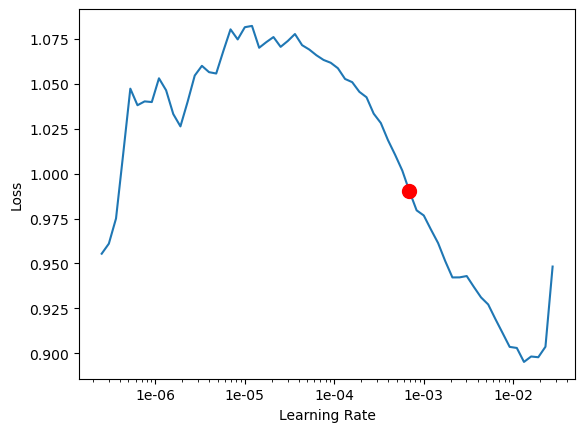

0.0006918309709189362

In [14]:
lr = model.lr_find()
lr

Next, we will train the model for a 350 epochs with the learning rate found above. If the loss continues to decrease, the model can be trained further until you start seeing overfitting.

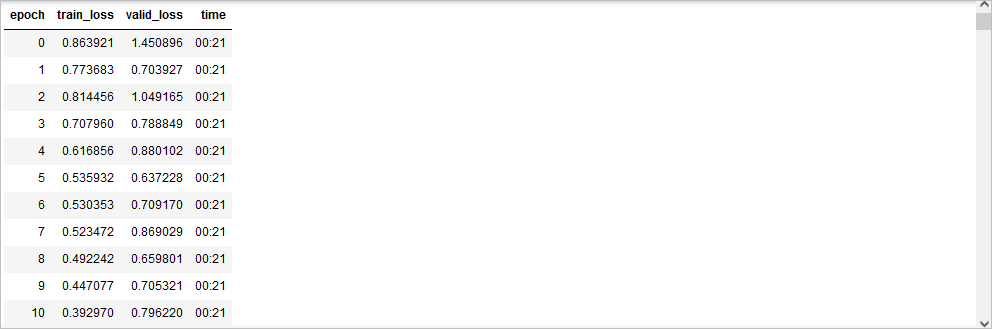

In [15]:
model.fit(350, lr=lr)

### Model accuracy and validation <a class="anchor" id="15"></a>

ClimaX provides the `compute_metrics()` method, which evaluates the model's performance. This will print out multiple model metrics for each of the variables fitted while training. Here, since we are forecasting `fwi_max`, we can assess the model quality using its corresponding metrics. These metrics include a combination of multiple evaluation criteria, such as `lat_weighted_rmse_fwi_max` (6.0983), `pearsonr_fwi_max`(0.8119), and `SSIM_fwi_max` (0.7095), which collectively measure the model's performance on the validation set.

In [16]:
model.compute_metrics()

{'lat_weighted_rmse_drought_code_max': 88.9128,
 'pearsonr_drought_code_max': 0.9524,
 'SSIM_drought_code_max': 0.8335,
 'lat_weighted_rmse_drought_code_mean': 86.7844,
 'pearsonr_drought_code_mean': 0.9525,
 'SSIM_drought_code_mean': 0.8203,
 'lat_weighted_rmse_fwi_max': 6.0983,
 'pearsonr_fwi_max': 0.8119,
 'SSIM_fwi_max': 0.7095,
 'lat_weighted_rmse_fwi_mean': 4.4272,
 'pearsonr_fwi_mean': 0.8068,
 'SSIM_fwi_mean': 0.6482,
 'lat_weighted_rmse_lai': 0.6418,
 'pearsonr_lai': 0.8831,
 'SSIM_lai': 0.7315,
 'lat_weighted_rmse_lccs_class_1': 6.3719,
 'pearsonr_lccs_class_1': 0.969,
 'SSIM_lccs_class_1': 0.8349,
 'lat_weighted_rmse_lccs_class_2': 7.6486,
 'pearsonr_lccs_class_2': 0.9644,
 'SSIM_lccs_class_2': 0.5705,
 'lat_weighted_rmse_lccs_class_3': 4.8685,
 'pearsonr_lccs_class_3': 0.9569,
 'SSIM_lccs_class_3': 0.7959,
 'lat_weighted_rmse_lccs_class_4': 2.1546,
 'pearsonr_lccs_class_4': 0.9472,
 'SSIM_lccs_class_4': 0.8039,
 'lat_weighted_rmse_lccs_class_5': 1.8908,
 'pearsonr_lccs_clas

We can see in the following plot that the training loss was reducing gradually.

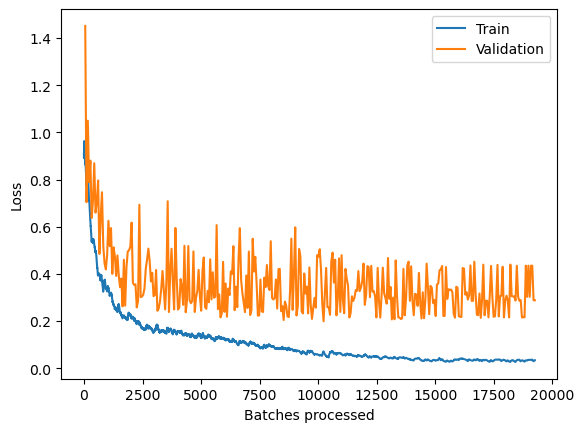

In [17]:
model.plot_losses()

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us the input state, the ground truth or target state  and model forecasted state, side by side. This enables us to preview the results of the model we trained.

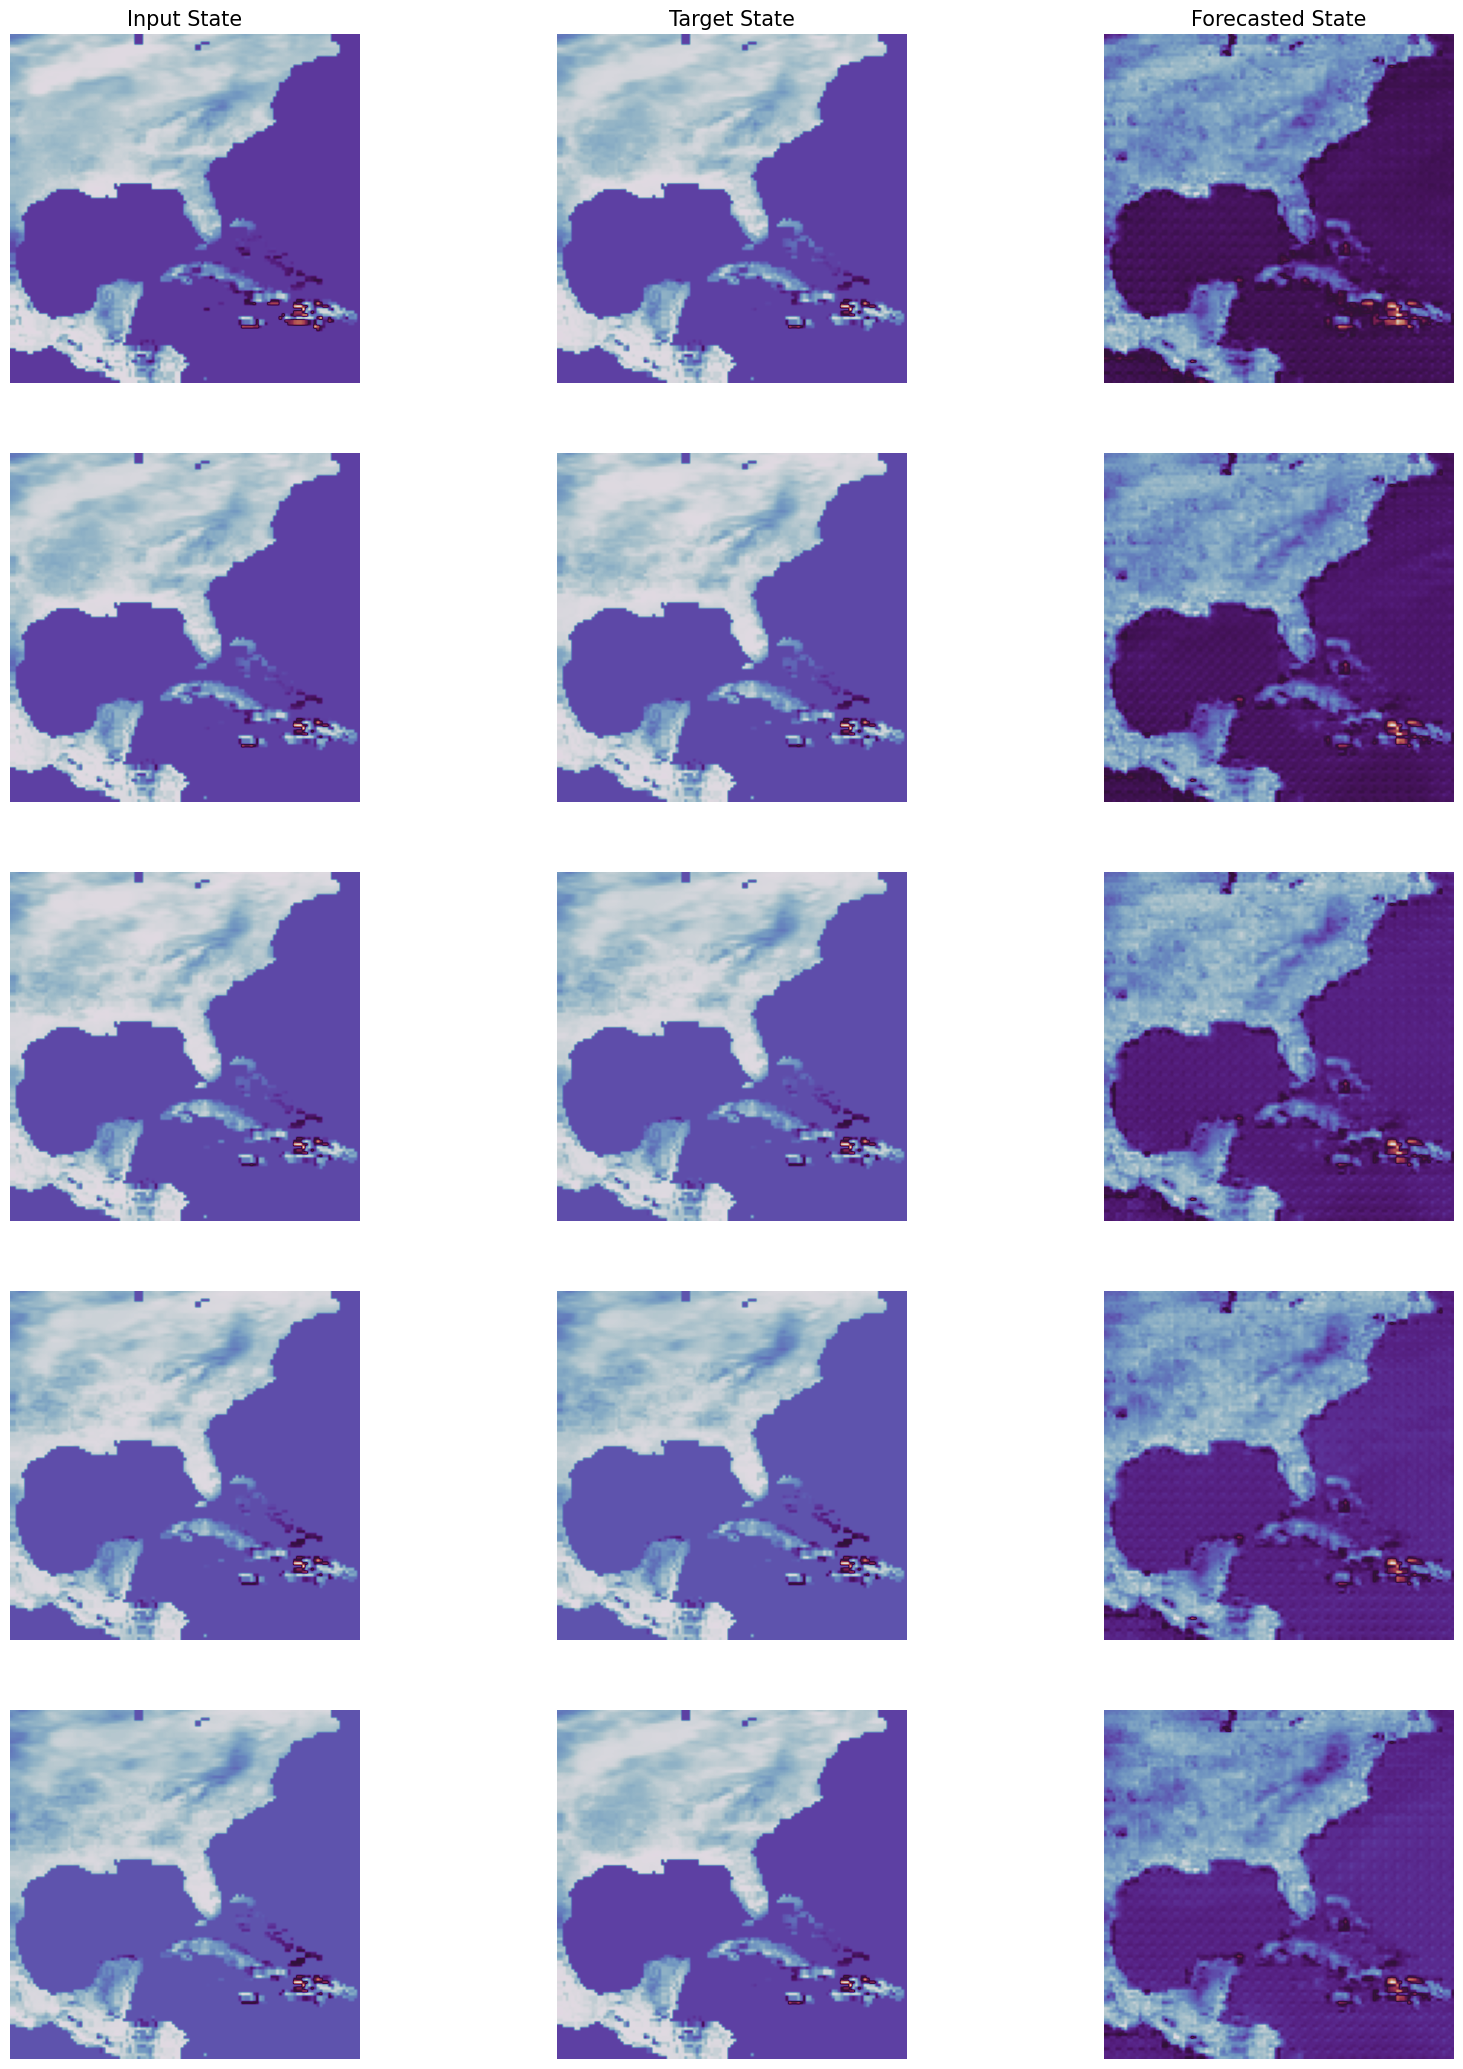

In [18]:
model.show_results(alpha=0.8)

## Save the model <a class="anchor" id="16"></a>

We will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the save() method to save the trained model. We can pass the folder path for saving the model. 

In [19]:
model.save("climax_wildfire_likelihood_forecast_v1.model", publish=True)

We can now use the saved model to forecast likelihood of wildfire.

## Inferencing in ArcGIS Pro <a class="anchor" id="18"></a>

After training the ClimaX forecasting model and saving the weights via the API, the Classify Pixels Using Deep Learning tool available in both [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Enterprise](https://www.esri.com/en-us/arcgis/products/arcgis-enterprise/overview) can be used for large-scale inferencing. The input raster for this tool is the one containing all variables at the final time step before forecasting. To extract the image of this final time step from a multidimensional raster, you can use the [subset multidimensional raster](https://pro.arcgis.com/en/pro-app/latest/tool-reference/multidimension/subset-multidimensional-raster.htm) tool.

We have provided the extracted multidimensional input raster containing all variables at the final timestamp before forecasting, in both `crf` and `tiff` format to be used as input raster for forecasting. Anyone can be used for this.

<Item title:"wildfire_weather_2021Dec_last_timestamp_crf" type:Image Collection owner:api_data_owner>
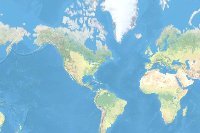

In [20]:
sample_inference_multidim_crf = gis.content.get('980305bf121243d5a7c724026caccd04')
sample_inference_multidim_crf

<Item title:"wildfire_weather_2021Dec_last_timestamp_tif" type:Image Collection owner:api_data_owner>
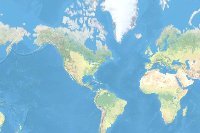

In [21]:
sample_inference_multidim_tif = gis.content.get('2c93674a3beb4158ac59c301439231dc')
sample_inference_multidim_tif

We have provided the trained model to use for inferencing.

<Item title:"climax_wildfire_likelihood_forecast_v1.model" type:Deep Learning Package owner:api_data_owner>
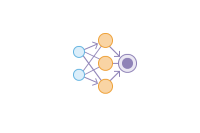

In [22]:
trained_model = gis.content.get('d7469ed2c3054f98ad4f4ce493762f97')
trained_model

In this step, we will use the Detect Objects Using Deep Learning tool available in both ArcGIS Pro and ArcGIS Enterprise to generate the forecasted multiband raster. Each band of the raster will be the forecasted wildfire likelihood surface for each timestep. The parameters are as follows:

- [ ] `padding` - 0
- [ ] `batch_size` - 4
- [ ] `output_variable` - fwi_max - the variable to be forecasted. You can forecast any other variable by specifying its respective name here.
- [ ] `number_of_time_steps_to_forecast` - 30 - the number of forecast periods of 30 is specified in this parameter, which defines the forecast duration. For this case, our dataset consists of 8-days intervals, hence it  would forecast 30 timesteps in the future each with 8 days intervals, which is for total of 240 days, from 2022 4th of January to 2022 24th August.

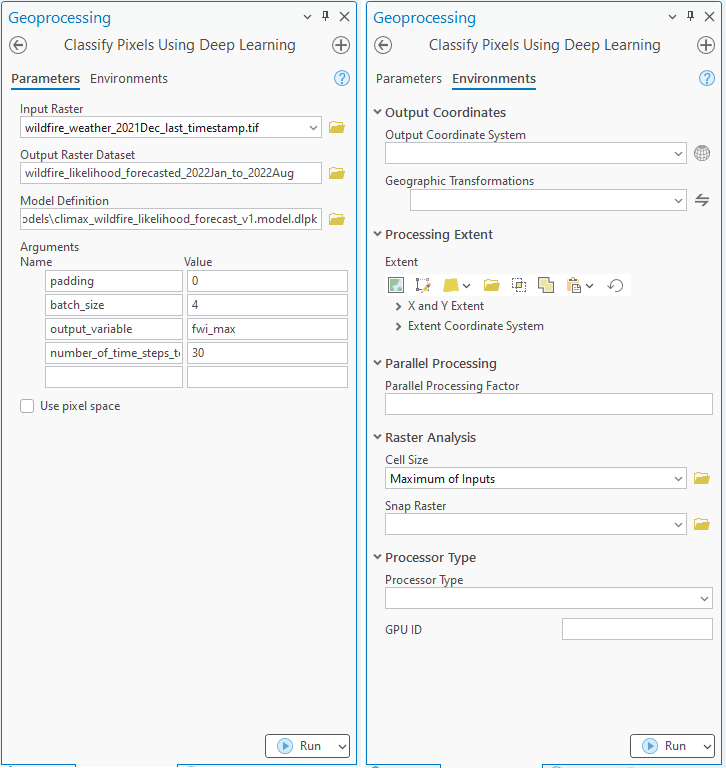


## Visualize results <a class="anchor" id="19"></a>
The model was run on the inference raster and will produce a multiband raster with 30 bands, where each band represents the forecasted wildfire risk surface for each timestamp with an interval of 8 days. The results can be viewed here. Let us visualize the first 5 forecasted wildfire risk surface, where the transition from red to green pixels indicates a shift from higher to lower risk of wildfire occurrences. 

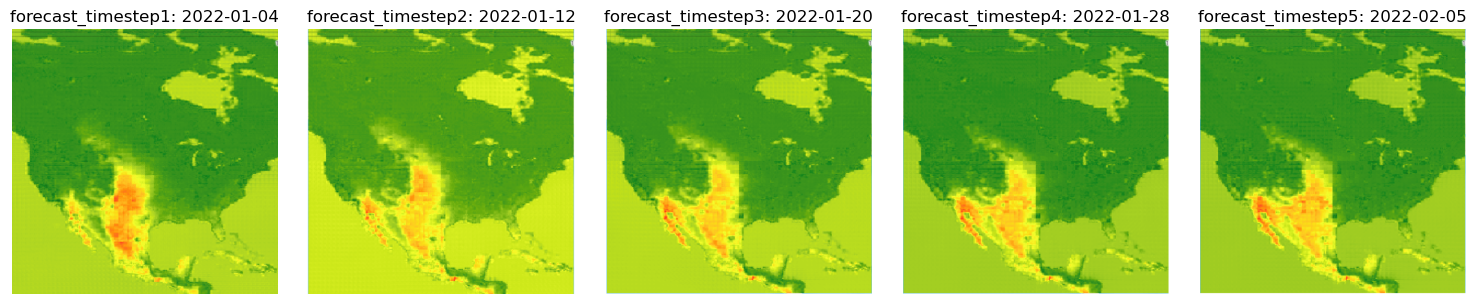

## Conclusion <a class="anchor" id="20"></a>

Time series forecasting is a challenging task that requires large historic dataset, extensive data preprocessing and an appropriate model. In this project, we seek to develop a sophisticated wildfire likelihood forecasting system leveraging the pretrained ClimaX foundation model and comprehensive weather data, with the goal of reducing the devastating impact of wildfires across the United States. 